# Exploration of Short Term Rental Data for Newport, RI
This notebook explores a few datasets related to short-term rentals in the City of Newport, RI, with the goal of better understanding the ability of the City to regulate this new business model and to examine the impacts on the residents of the city.

The first dataset is a collection of AirBnB listings in Rhode Island collected from the website.  These data represent a snapshot of the actual properties being rented on the platform.

The second dataset is the registration information that transient guest facility (including short-term rentals) operators are required to register with the city.  These data represent information reported by owners, and does not account for owners operating outside the regulatory framework within the city.

The third dataset is from the property tax assessor for the City of Newport.  This data represents formal documentation of the physical properties, and the data are considered to have good accuracy.

These datasets are best-available data.  Some caveats are noted herein, but there are likely unidentified factors that influence the data which haven't been accounted for.

This work is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/). ![Creative Commons License](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
from folium import plugins
import numpy as np

## Rhode Island AirBnB Listings in July 2021
This dataset was collected from publicly facing data from the AirBnB service in July 2021.

In [3]:
abb_raw = pd.read_excel('Raw Data AirBNB 7_23_2021.xlsx', dtype={'room_type':'category'})
abb_raw.drop(labels=['host_name'], axis=1, inplace=True)
geom = [Point(xy) for xy in zip(abb_raw.longitude, abb_raw.latitude)]
abb_data = gpd.GeoDataFrame(abb_raw, crs='epsg:4326', geometry=geom)

### Density of AirBnB in RI

In [4]:
map = folium.Map(location=[41.6, -71.5], tiles='Stamen toner', zoom_start=9)
heat_data = [[point.xy[1][0], point.xy[0][0]] for point in abb_data.geometry]
plugins.HeatMap(heat_data).add_to(map)
map

Newport is the main tourist attraction in Rhode Island, so it would be interesting to see how many of the AirBnBs listed in the state are in Newport.

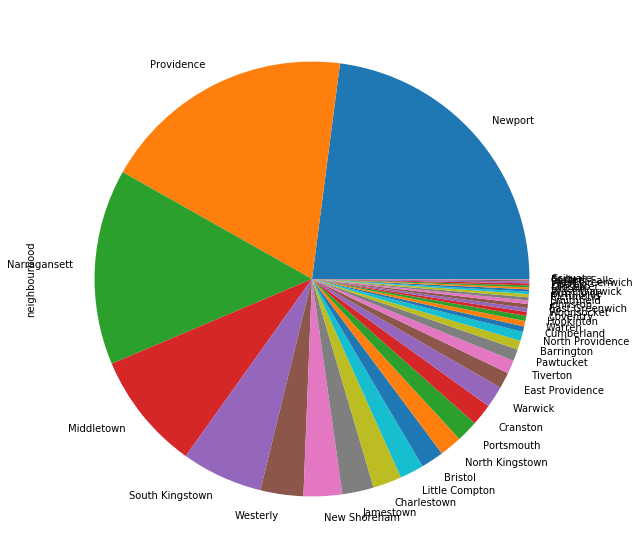

In [5]:
city_listing_count = abb_data['neighbourhood'].value_counts()
city_listing_count.plot.pie(figsize=[10,10])
plt.show()

In [6]:
# calculate the percentage of RI airbnbs in newport
city_listing_count['Newport'] / city_listing_count.sum()

0.22939801285797778

That's 23% of the listings, and the single largest market for listings beating out the largest city in the state.  The dataset also tells us what kinds of properties are listed.  Let's zoom in on Newport.

In [7]:
npt_abb = abb_data[abb_data['neighbourhood']=='Newport']
npt_abb['room_type'].value_counts()

Entire home/apt    579
Private room       170
Hotel room          32
Shared room          4
Name: room_type, dtype: int64

In [8]:
len(npt_abb)  # total listings in newport

785

The listings in Newport are predominantly entire homes or apartments; in other words, these are complete dwelling units that are being used for short term stays.  We haven't looked at how often these units are rented - some of these might be generating some extra cash for the residents when they vacation somewhere else!  Let's take a look. 

In [9]:
npt_abb.groupby(by='room_type')['availability_365'].describe()  # assumes availability_365 means number of days listed per year

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,579.0,151.411054,121.228674,0.0,28.50,137.0,268.50,365.0
Hotel room,32.0,172.750000,81.256265,0.0,104.75,190.0,221.50,365.0
Private room,170.0,135.388235,131.168945,0.0,9.25,87.0,239.75,365.0
Shared room,4.0,242.750000,167.663105,0.0,197.25,303.0,348.50,365.0


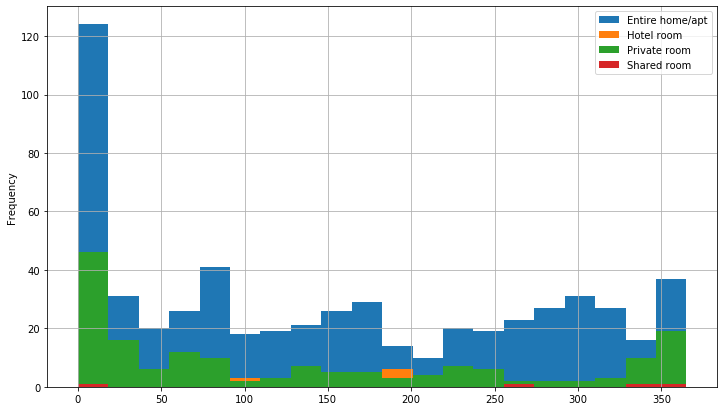

In [10]:
npt_abb.groupby(by='room_type')['availability_365'].plot.hist(bins=20, legend=True, figsize=[12,7], grid=True)
plt.show()

According to this dataset, 1/4 of the `entire home/apt` listings are available for less than one month in a year.  It also shows 1/4 of those listings are availablle 9 months out of the year.

In [16]:
parcels = gpd.read_file('../Newport-Parcel/Newport_Parcels20171011.shp')  # parcel data provided by the city of newport in 2017.

Newport, like most American cities, governs land use through zoning ordinances. Most of the regulations for short-term rentals is included in the zoning.  Plotting the estimated AirBnB locations (marked with black 'x') on the zoning map helps show the zones with more AirBnB properties.  Remember that these locations are not necessarily exact, and this may result in mis-labeling the zoning for properties close to a boundary.

**Note - Parcel and zoning data is not up to date, and does not include the new zoning that accompanied the North End Urban Plan as adopted in 2021.**

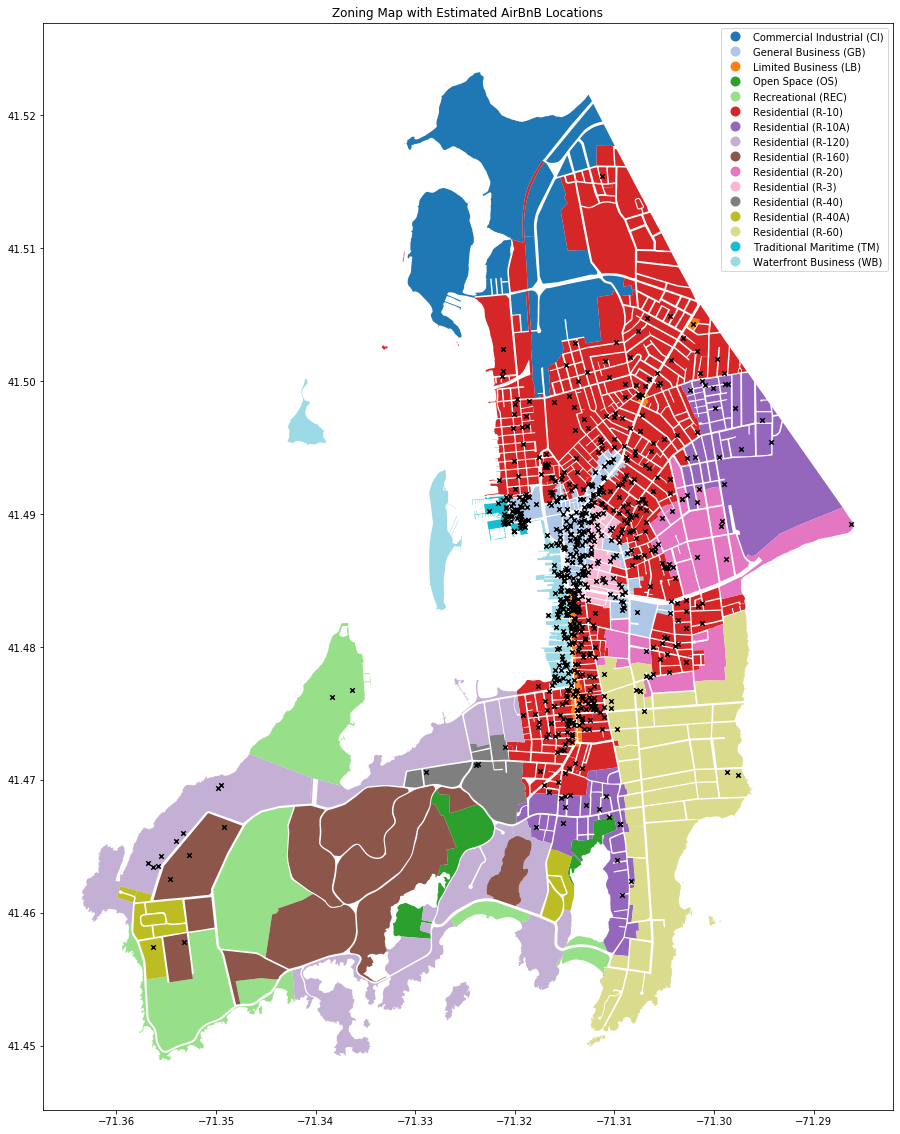

In [107]:
base = parcels.to_crs(4326).dissolve(by='Zone').reset_index().plot(column='Zone', figsize=(20,20), legend=True, cmap='tab20')
abb_data[abb_data['neighbourhood']=='Newport'].plot(ax=base, marker='x', color='black', markersize=20)
plt.title('Zoning Map with Estimated AirBnB Locations')
plt.show()

In [108]:
abb_zones = abb_data.sjoin(parcels.to_crs('epsg:4326').dissolve(by='Zone').reset_index())  # geospatial join to attach underlying zone data to airbnb listings

We can count the number of these listings are in each zone.

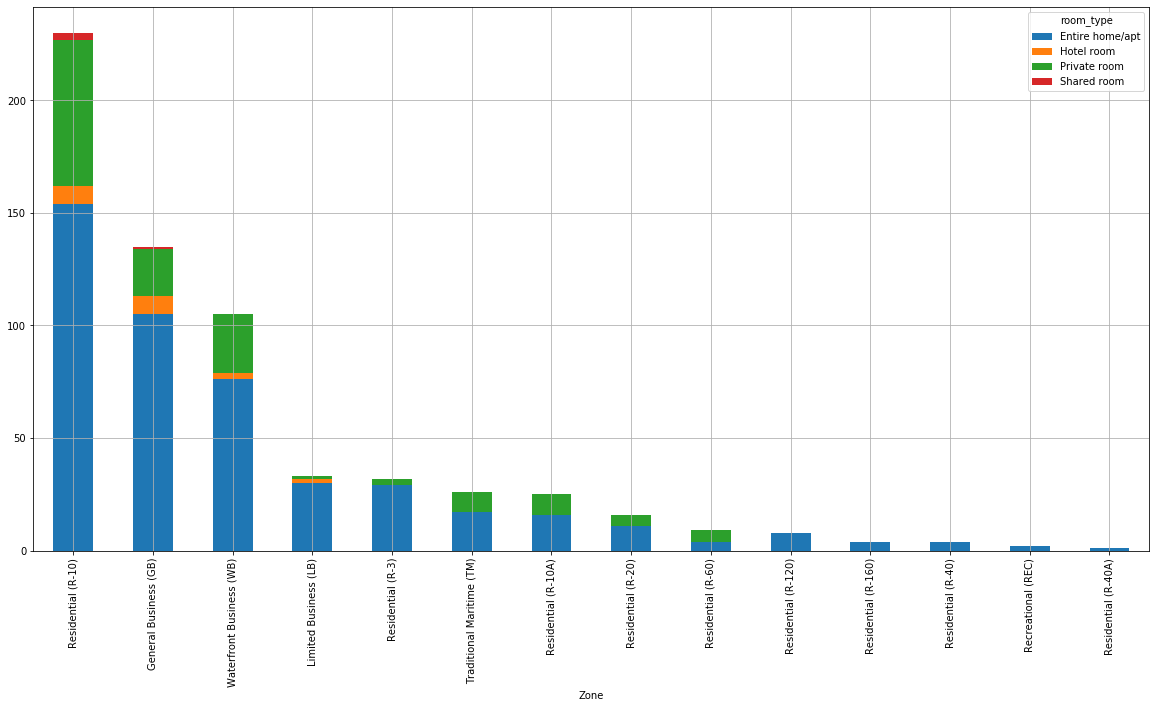

In [145]:
zone_order = ['Residential (R-10)', 'General Business (GB)', 'Waterfront Business (WB)', 'Limited Business (LB)', 'Residential (R-3)', 'Traditional Maritime (TM)', 'Residential (R-10A)', 'Residential (R-20)', 'Residential (R-60)', 'Residential (R-120)', 'Residential (R-160)', 'Residential (R-40)', 'Recreational (REC)', 'Residential (R-40A)']
abb_zones[['room_type','Zone']].groupby('Zone')['room_type'].value_counts().unstack().reindex(zone_order).plot.bar(figsize=(20,10), stacked=True, grid=True)
plt.show()

And we can calculate the percentage of listings are in each zone.

In [141]:
abb_zones['Zone'].value_counts()/len(abb_zones)

Residential (R-10)           0.365079
General Business (GB)        0.214286
Waterfront Business (WB)     0.166667
Limited Business (LB)        0.052381
Residential (R-3)            0.050794
Traditional Maritime (TM)    0.041270
Residential (R-10A)          0.039683
Residential (R-20)           0.025397
Residential (R-60)           0.014286
Residential (R-120)          0.012698
Residential (R-160)          0.006349
Residential (R-40)           0.006349
Recreational (REC)           0.003175
Residential (R-40A)          0.001587
Name: Zone, dtype: float64

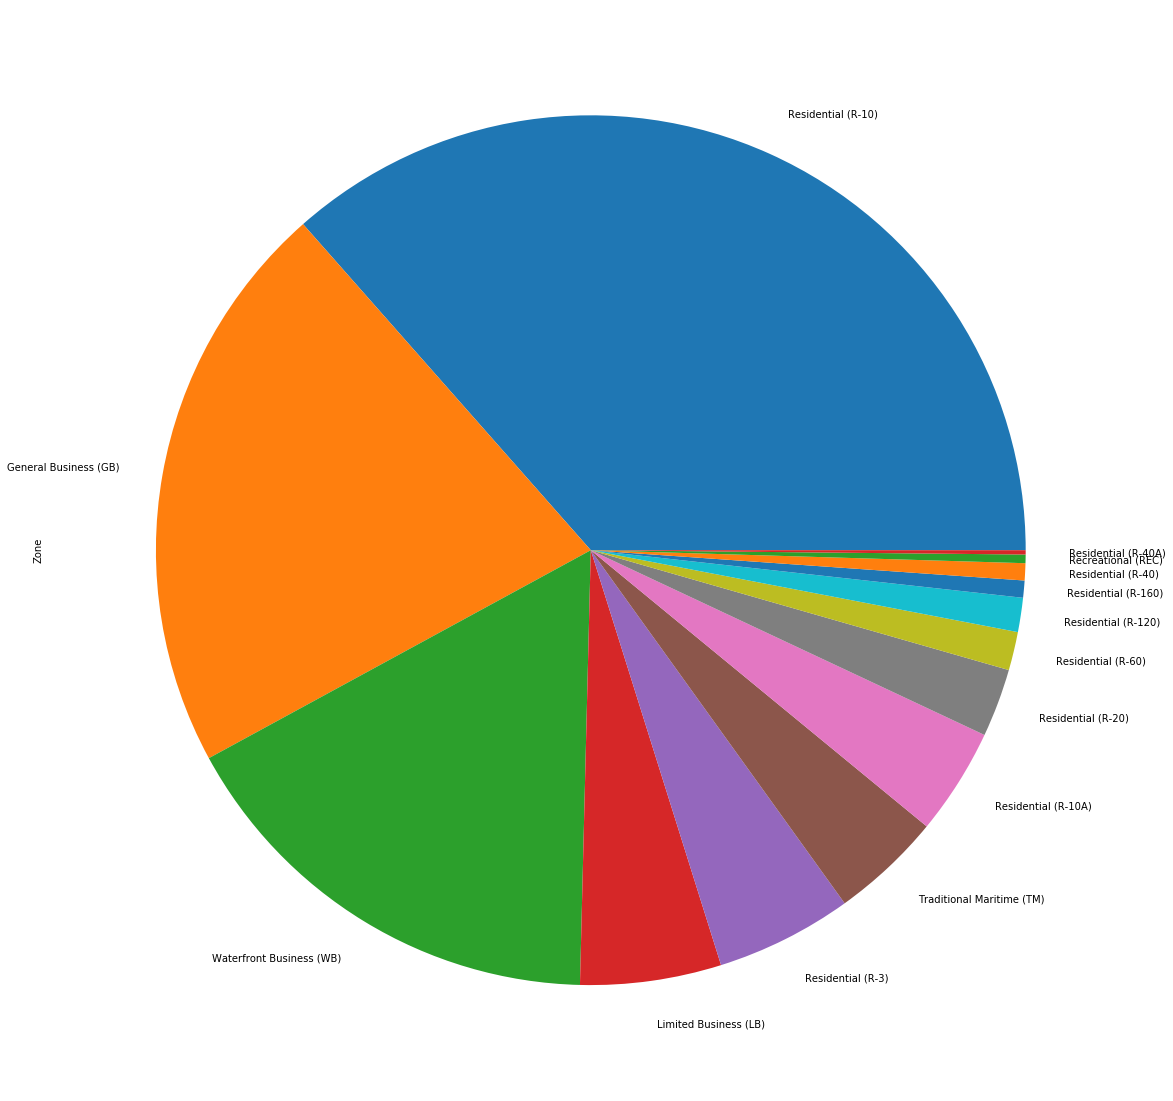

In [146]:
abb_zones['Zone'].value_counts().plot.pie(figsize=(20,20))
plt.show()

## City of Newport Registered Transient Guest Facilities 2021
This data was provided by the City of Newport in 2021.  It represents only the facilities that have registered with the city.  This analysis assumes all properties are actively being used as short term rentals.

In [11]:
guest_facility_data = pd.read_excel('Copy of Transient Guest Facilities 2021.xlsx', dtype={'Plat': 'str', 'Zoning District':'category', 'Type of Property':'category'})
guest_facility_data.drop(labels=['Email', "Owner's phone #"], axis=1, inplace=True)  # censor contact information
guest_facility_data = guest_facility_data[1:]  # drop the test record at the start of the file

# clean data
guest_facility_data.replace(
    to_replace={'Mixed-Use':'Mixed Use', 
                'Comm. Condo': 'Comm Condo', 
                'Single':'Single Family', 
                'Singe Family': 'Single Family',
                'Three-Family': 'Three Family',
                'Condo': 'Res Condo',
                'Two-Family': 'Two Family',
                'Timeshare Condos': 'Timeshare',
                'Single family': 'Single Family',
                'Four Family': 'Multi Family',
                'Five Family': 'Multi Family',
                'Multi-Family': 'Multi Family',
                'No':'no'
               },
    inplace=True)

In [12]:
len(guest_facility_data)  # number of registration records

461

In Newport, transient guest facilities are allowed in business districts by right.  However, a concern is that these guest facilities are encroaching on resident housing in residential zones, which require special use permits.

In [13]:
guest_facility_data['Zoning District'].value_counts()

R10     172
GB      111
LB       52
WB       48
R10A     23
R3       19
R20      15
R120      8
CI        4
R60       3
R40       3
TM        1
G         1
Name: Zoning District, dtype: int64

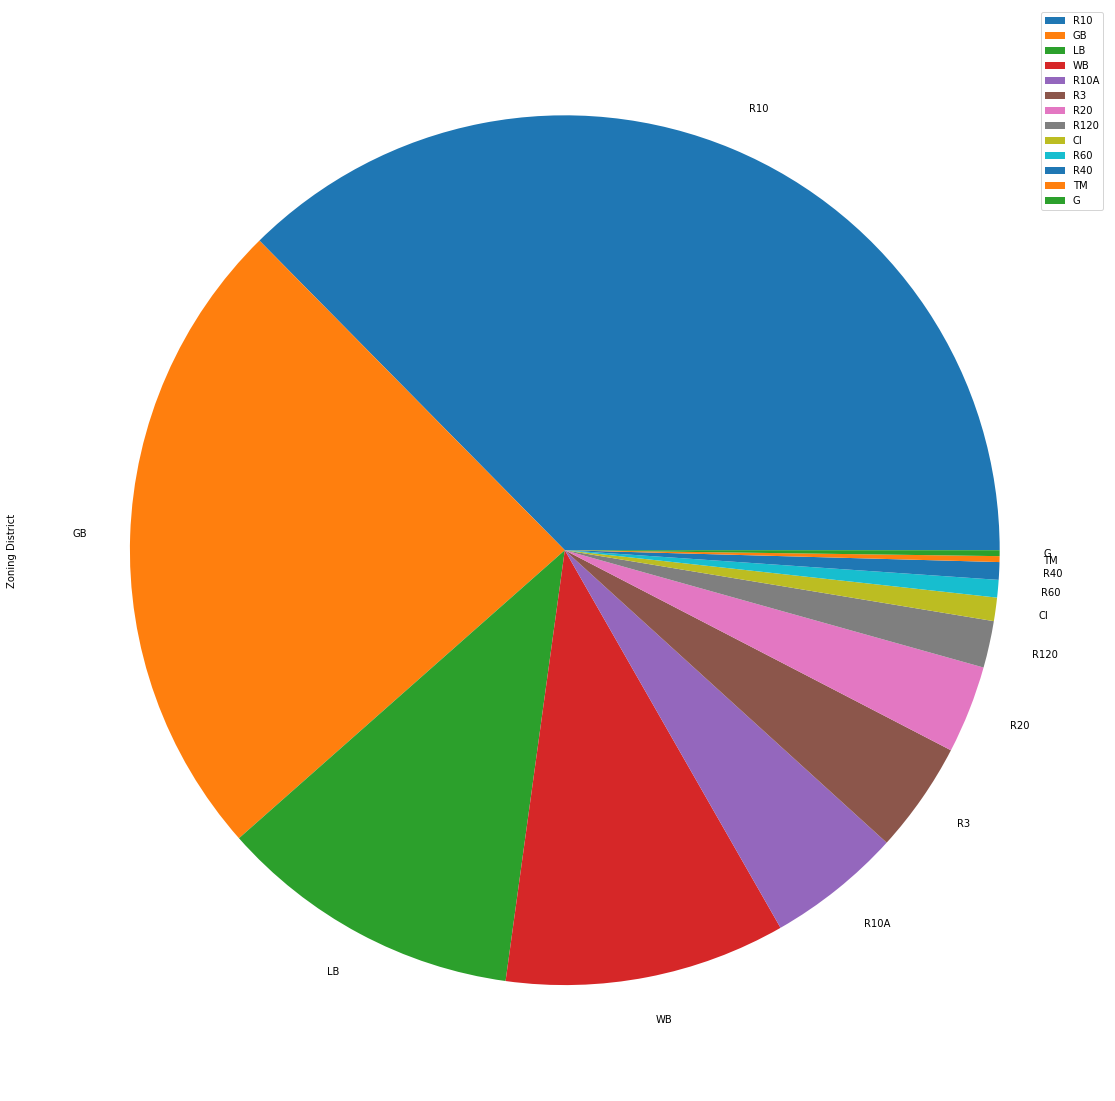

In [144]:
guest_facility_data['Zoning District'].value_counts().plot.pie(legend=True, figsize=[20,20])
plt.show()

The data show that many of the registered guest facilities are in fact on land designated for residential use by the city's zoning ordinances.  We can calculate that proportion:

In [15]:
guest_facility_data['Zoning District'].value_counts()[['R10', 'R10A', 'R3', 'R20', 'R120', 'R60', 'R40']].sum() / guest_facility_data['Zoning District'].value_counts().sum()

0.5282608695652173

That is over 50% of the registered properties operating in residential zones!  It is little surprise that R10 is well represented in the data.  R10 zones are situated within easy walking distance of many of active business districts that feature dining and nightlife.  R10 zones also have some of the more accessible housing stock, i.e. modestly sized single family homes with moderate density.  We can examine the data to see what types of property are listed.

In [18]:
guest_facility_data['Type of Property'].value_counts()

Single Family              147
Two Family                  83
B&B/Inn                     49
Mixed Use                   48
Res Condo                   26
Comm Condo                  19
Three Family                17
Stores/Apt Com              17
Hotel                       13
Large Bus                   11
Apartment                    8
Multi Family                 7
Timeshare                    7
Res Type Comm                3
Estate                       1
Charitable                   1
Res2RmRent                   1
Large Business- 4 Story      1
Cottage                      1
Name: Type of Property, dtype: int64

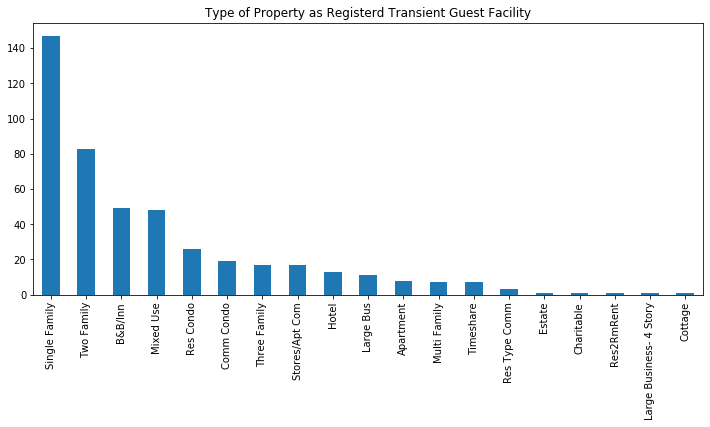

In [19]:
guest_facility_data['Type of Property'].value_counts().plot.bar(figsize=(12,5))
plt.title('Type of Property as Registerd Transient Guest Facility')
plt.show()

The dataset doesn't seem to have high quality data in this field.  There are possible overlaps among the categories, and they are not well defined.  Looking at how many rooms are available might also help understand the properties that are being rented.

In [20]:
guest_facility_data.groupby(by='Type of Property')[['Number of rooms']].describe()


Number of rooms                                     \
                                  count       mean         std   min   25%   
Type of Property                                                             
Apartment                           8.0   2.625000    1.060660   2.0   2.0   
B&B/Inn                            49.0   8.755102    5.265970   2.0   5.0   
Charitable                          1.0  10.000000         NaN  10.0  10.0   
Comm Condo                         19.0   9.842105   14.829637   2.0   3.0   
Cottage                             1.0   1.000000         NaN   1.0   1.0   
Estate                              1.0   2.000000         NaN   2.0   2.0   
Hotel                              13.0  88.461538  107.692940   2.0  10.0   
Large Bus                          11.0  49.909091   56.456097   2.0  15.0   
Large Business- 4 Story             1.0   6.000000         NaN   6.0   6.0   
Mixed Use                          48.0   3.062500    3.910739   1.0   1.0   
Multi Family                        7.0   3.571429    2.572751   1.0   2.0   
Res Condo                          26.0   2.269231    2.182800   1.0   1.0   
Res Type Comm                       3.0   2.000000    0.000000   2.0   2.0   
Res2RmRent                          1.0   2.000000         NaN   2.0   2.0   
Single Family                     147.0   2.108844    1.375566   1.0   1.0   
Stores/Apt Com                     17.0   2.764706    1.393261   1.0   2.0   
Three Family                       17.0   2.529412    1.374666   1.0   2.0   
Timeshare                           7.0  36.428571   32.572264  11.0  14.5   
Two Family                         83.0   2.108434    1.147766   1.0   1.5   

                                             
                          50%    75%    max  
Type of Property                             
Apartment                 2.0    3.0    5.0  
B&B/Inn                   7.0   12.0   23.0  
Charitable               10.0   10.0   10.0  
Comm Condo                3.0    9.0   58.0  
Cottage                   1.0    1.0    1.0  
Estate                    2.0    2.0    2.0  
Hotel                    33.0  133.0  320.0  
Large Bus                33.0   66.5  200.0  
Large Business- 4 Story   6.0    6.0    6.0  
Mixed Use                 2.0    4.0   28.0  
Multi Family              2.0    5.0    8.0  
Res Condo                 2.0    2.0   12.0  
Res Type Comm             2.0    2.0    2.0  
Res2RmRent                2.0    2.0    2.0  
Single Family             2.0    2.0   11.0  
Stores/Apt Com            3.0    4.0    5.0  
Three Family              2.0    3.0    5.0  
Timeshare                22.0   45.5  102.0  
Two Family                2.0    2.0    7.0

While it is difficult to draw conclusive insights from this particular analysis, it is apparent that many of the properties are renting only a few rooms, regardless of the category of the property.  We can look at this directly.

In [21]:
guest_facility_data[['Number of rooms']].describe()

,Number of rooms
count,461.000000
mean,7.436009
std,25.737866
min,1.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,320.000000


The registered properties are overwhelmingly renting a few rooms.  Since the overall quality of the dataset is mediocre, it is not clear if these are rooms per unit, or units per property.  Likely, the responses include some mix of these interpretations.

We can also look at the owners of the property.  A property with a resident owner is more likely to be providing some amount of housing stock for Newport residents, however the definition is unclear at this point.  It is probably safe to assume that a property with no resident owner is not providing housing for Newport residents.

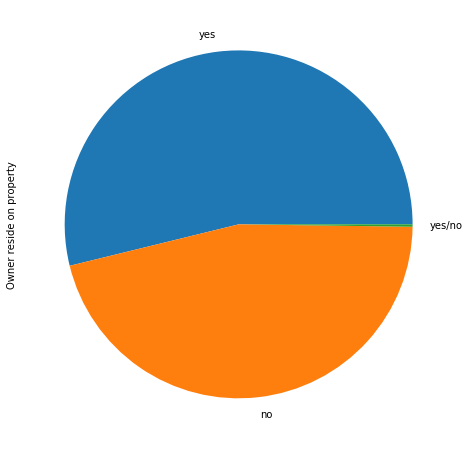

In [22]:
guest_facility_data['Owner reside on property'].value_counts().plot.pie(figsize=[8,8])
plt.show()

Looking at it another way, we see which properties in which zones are owner occupied.

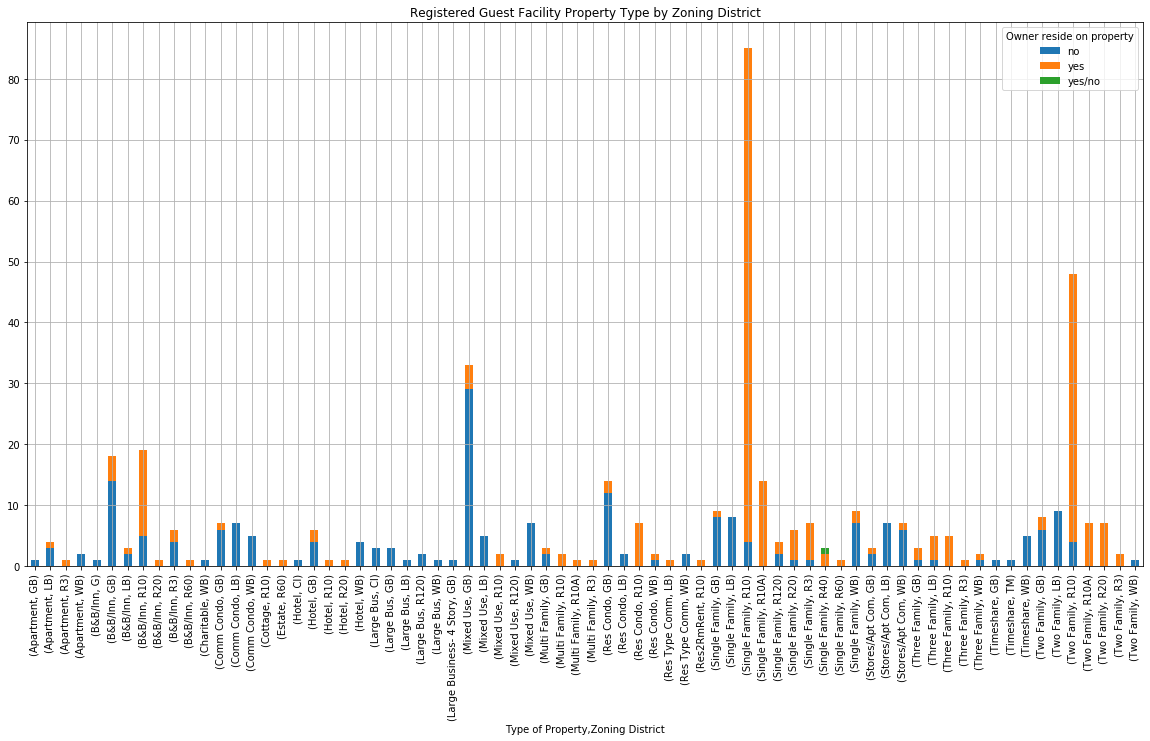

In [102]:
guest_facility_data.groupby(['Type of Property', 'Zoning District'])['Owner reside on property'].value_counts().unstack().plot.bar(figsize=(20,10), stacked=True, grid=True)
plt.title("Registered Guest Facility Property Type by Zoning District")
plt.show()

We can get also see how many owners are local (or at least have a locally registered business) compared with out of state owners.

In [23]:
guest_facility_data['State'].value_counts()

RI    397
MA     30
NY     11
CT      8
FL      3
NJ      3
OR      2
ME      1
CA      1
MI      1
R       1
PA      1
VA      1
TX      1
Name: State, dtype: int64

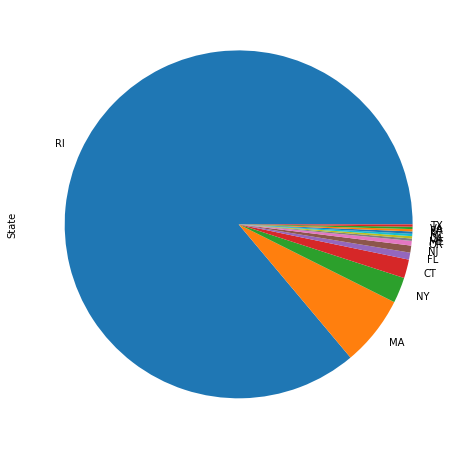

In [24]:
guest_facility_data['State'].value_counts().plot.pie(figsize=[8,8])
plt.show()

Most registered property owners have their business address in RI.  This result should be interpreted with caution; short term rental laws vary widely across the country, so it is much less likely that an out of state owner would know to register with the municipality in Newport.  This is further compounded by the lack of enforcement at the state level, and the practical challenges of enforcement at the local level.

## Property Records
We can get more insight into property use and ownership through publicly available property records.  We'll dig into a dataset from the tax assessor's database, accessed in October 2021.

In [25]:
property_data = pd.read_csv('../newport-property-assessments/newport_property_cleaned.csv', index_col=0, dtype={'year_built': 'Int64', 'fireplaces':'Int64'})

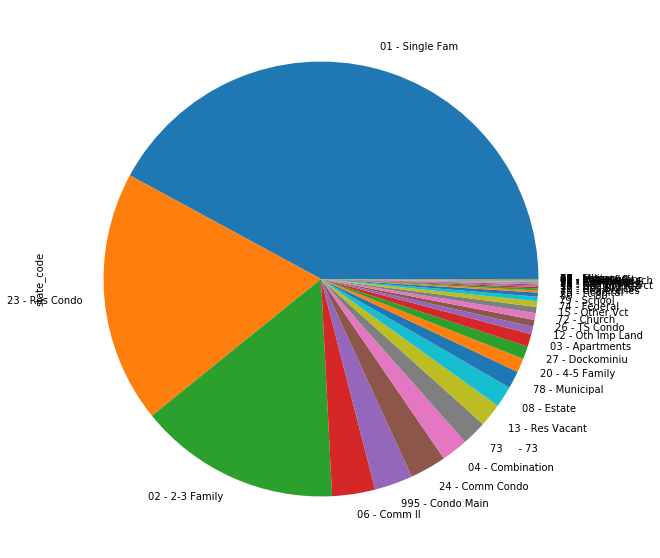

In [26]:
property_data['state_code'].value_counts().plot.pie(figsize=(10,10))

A simple, reasonable measure of determining if a property is owner occupied is to match the registered address of the owner with the address of the property itself.  By this measure, there are 4233 owner-occupied properties (including residences and businesses).

There are probably a few cases where this test would give an incorrect result, but we'll assume that it is negligible when analyzing the full dataset.

In [27]:
# first pass at identifying owner occupied - match property address to owner address, include second owner address field for formatting differences
property_data['owner_occupied'] = (property_data['parcel_location'] == property_data['owner_address']) | (property_data['parcel_location'] == property_data['owner_address2'])
# count how many properties are owner-occupied
sum(property_data['owner_occupied'])

4233

A comparison measure is the 2019 American Community Survey 5-Year Estimate for owner-occupied housing units ([table S2501](https://data.census.gov/cedsci/table?q=housing&g=8600000US02840&tid=ACSST5Y2019.S2504)) in zip code 02840, which estimated 4373 owner-occupied housing units, with a margin of error of +/-319.

It'll be helpful to group the data by a couple key parameters: land use (e.g. single family) and zoning (e.g. R-10).  These are important because they play directly into the legality of using the property as a short term rental.

In [28]:
# group properties by use code, and by zone
property_use_grouped = property_data.groupby(by=['state_code', 'zone'])
property_zone_grouped = property_data.groupby(by=['zone', 'state_code'])

Let's start by looking at homeownership by zone.  These plots show the types of properties in the zone, and the proportion of owner occupation by property use.

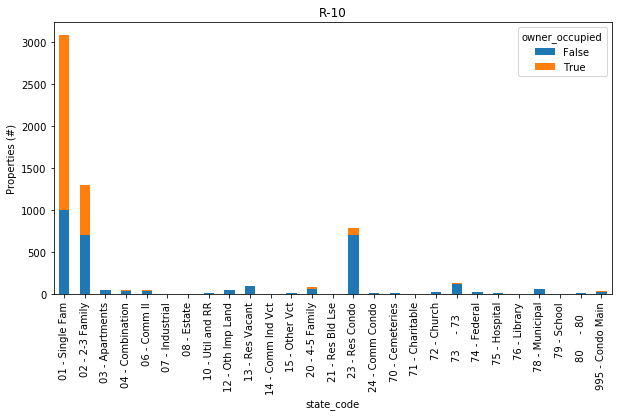

In [29]:
property_zone_grouped['owner_occupied'].value_counts().loc['R10'].unstack().plot.bar(stacked=True,title='R-10', figsize=(10,5))
plt.ylabel('Properties (#)')
plt.show()

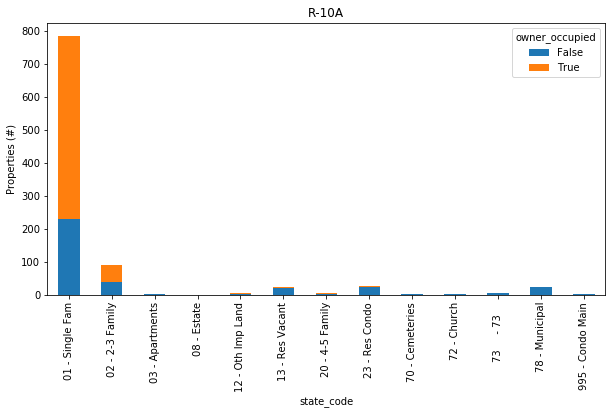

In [30]:
property_zone_grouped['owner_occupied'].value_counts().loc['R10A'].unstack().plot.bar(stacked=True,title='R-10A', figsize=(10,5))
plt.ylabel('Properties (#)')
plt.show()

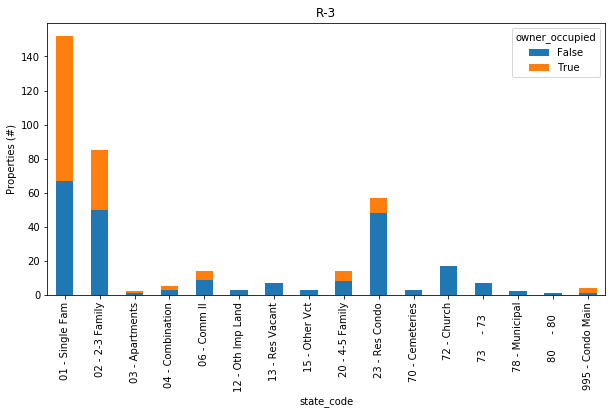

In [31]:
property_zone_grouped['owner_occupied'].value_counts().loc['R3'].unstack().plot.bar(stacked=True,title='R-3', figsize=(10,5))
plt.ylabel('Properties (#)')
plt.show()

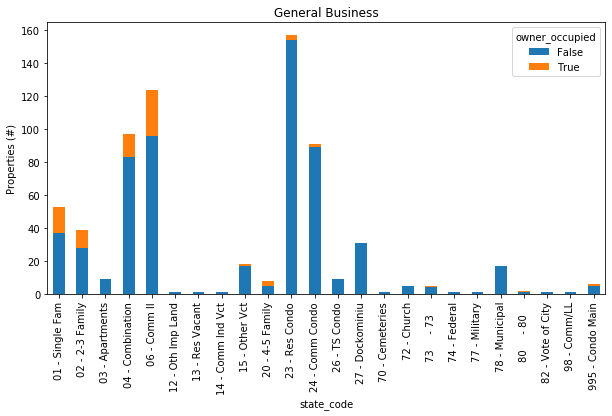

In [32]:
property_zone_grouped['owner_occupied'].value_counts().loc['GB'].unstack().plot.bar(stacked=True,title='General Business', figsize=(10,5))
plt.ylabel('Properties (#)')
plt.show()

And we can also look at the data by property use.  The next few plots show what zones the property type are in, and how much of it is owner occupied.

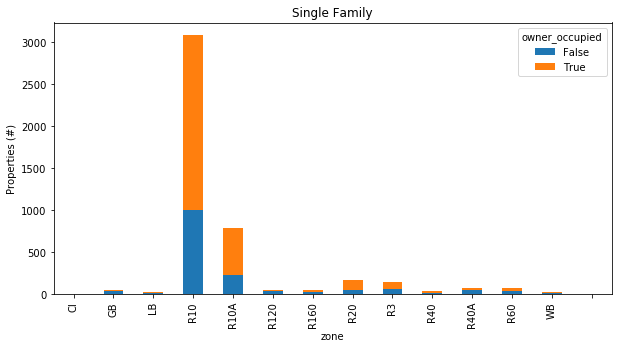

In [33]:
property_use_grouped['owner_occupied'].value_counts().loc['01 - Single Fam'].unstack().plot.bar(stacked=True,title='Single Family', figsize=(10,5))
plt.ylabel('Properties (#)')
plt.show()

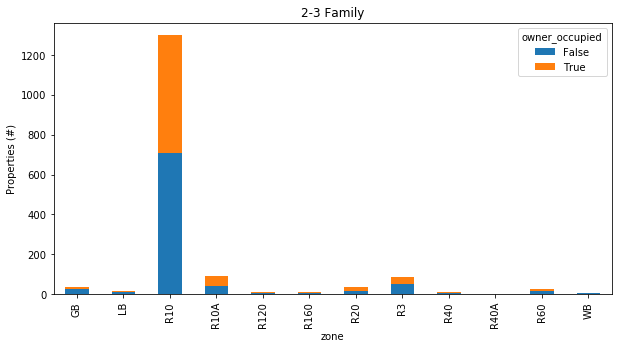

In [34]:
property_use_grouped['owner_occupied'].value_counts().loc['02 - 2-3 Family'].unstack().plot.bar(stacked=True,title='2-3 Family', figsize=(10,5))
plt.ylabel('Properties (#)')
plt.show()

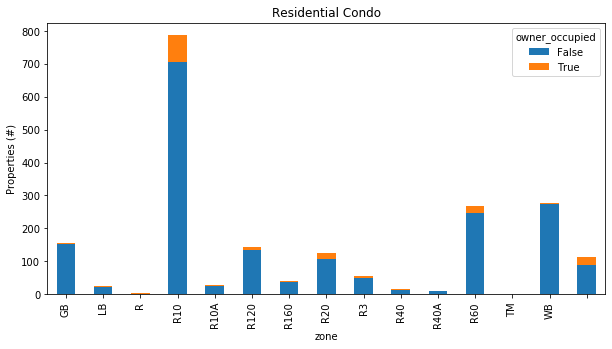

In [35]:
property_use_grouped['owner_occupied'].value_counts().loc['23 - Res Condo'].unstack().plot.bar(stacked=True,title='Residential Condo', figsize=(10,5))
plt.ylabel('Properties (#)')
plt.show()

Another way to assess housing capacity is to count the number of available bedrooms.  This view helps to measure the density of housing on properties.  This is a rough and subjective measure, since "bedrooms" are often used for offices or other functional rooms.  However, there is a general positive correlation with the number of bedrooms and the number of people housed, and it is assumed to be sufficient for analyzing trends and macro effects.

The following figure shows the number of bedrooms in the city by property type.

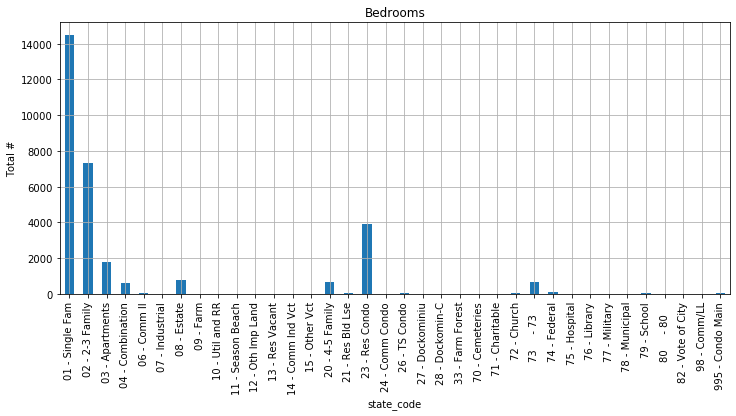

In [36]:
property_data.groupby('state_code')['bedrooms'].sum().plot.bar(figsize=(12,5), grid=True)
plt.title('Bedrooms')
plt.ylabel('Total #')
plt.show()

We can break this measure down further, looking at capacity distribution across zones by property use.  The following table shows the total bedrooms in each zone per use code.

In [37]:
property_use_grouped['bedrooms'].sum().unstack().replace(0,np.NaN).dropna(how='all').dropna(how='all', axis=1).fillna('-')

zone,160,CI,GB,LB,R,R-10,R10,R10A,R120,R160,R20,R3,R40,R40A,R60,TM,WB,
state_code,,,,,,,,,,,,,,,,,,
01 - Single Fam,-,6,170,96,-,-,9517,2398,203,165,619,499,143,266,311,-,62,14
02 - 2-3 Family,-,-,162,88,-,-,5918,345,55,42,150,385,45,6,120,-,26,-
03 - Apartments,-,-,105,-,-,-,1437,21,-,-,56,8,20,43,114,-,-,12
04 - Combination,-,2,352,76,-,-,121,-,9,-,10,11,-,-,-,-,50,-
06 - Comm II,-,-,19,-,-,-,20,-,-,3,3,-,-,-,11,-,2,-
08 - Estate,-,-,-,-,-,-,5,5,178,139,62,-,7,-,412,-,-,-
09 - Farm,-,-,-,-,-,-,-,-,3,-,-,-,-,-,-,-,-,-
20 - 4-5 Family,-,-,45,11,-,-,493,33,-,-,15,89,-,-,7,-,-,-
21 - Res Bld Lse,-,-,-,-,-,-,6,-,-,-,-,-,-,-,-,-,-,26


Most of the housing capacity in Newport is within single-family homes, which shouldn't come as a surprise to those familiar with the area.  One way we can frame the risk posed by unregistered short term rentals is proportional to the amount of housing stock that is not allowed to be used as short term rentals by right.  

The following tables and figures look at *residential properties* in a *residential zone* that are *not owner-occupied*.  Non-compliant short term rentals that are available *today* would exist within this set of properties.

**Caution - This data analysis does not currently include second units in an owner-occupied multi-family home**

In [38]:
risk_residential = property_data[property_data['owner_occupied'] == False].groupby(['state_code', 'zone']).size().unstack().drop(['CI', 'GB', 'LB', 'WB'], axis=1).filter(['01 - Single Fam', '02 - 2-3 Family', '03 - Apartments', '20 - 4-5 Family', '23 - Res Condo'], axis=0).dropna(how='all', axis=1).dropna(how='all')
risk_residential.fillna('-')

zone,R,R10,R10A,R120,R160,R20,R3,R40,R40A,R60,TM,
state_code,,,,,,,,,,,,
01 - Single Fam,-,1004.0,229.0,36,29,57.0,67.0,13,55,45.0,-,2
02 - 2-3 Family,-,708.0,40.0,9,7,16.0,50.0,7,1,18.0,-,-
03 - Apartments,-,47.0,3.0,-,-,6.0,1.0,4,8,11.0,-,1
20 - 4-5 Family,-,60.0,3.0,-,-,2.0,8.0,-,-,1.0,-,-
23 - Res Condo,2,705.0,25.0,135,36,106.0,48.0,14,9,247.0,1,89


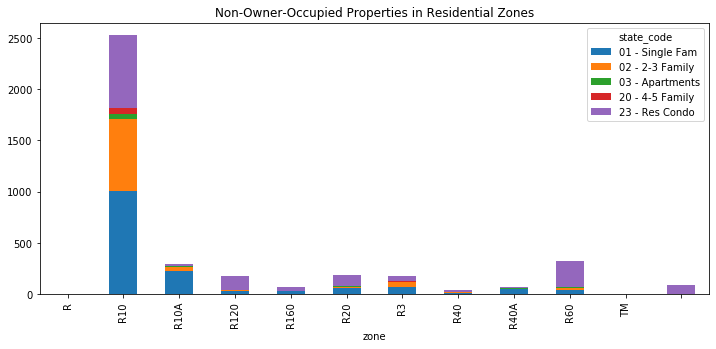

In [92]:
risk_residential.T.plot.bar(figsize=(12,5), stacked=True)
plt.title('Non-Owner-Occupied Properties in Residential Zones')
plt.show()

There are 3965 total properties in this risk category.  It should be noted that all of these properties may also be rented to year-round residents, so this provides an upper bound to the number of properties that should be protected from non-compliant short-term rentals.

In [40]:
risk_residential.sum(axis=1).sum()

3965.0

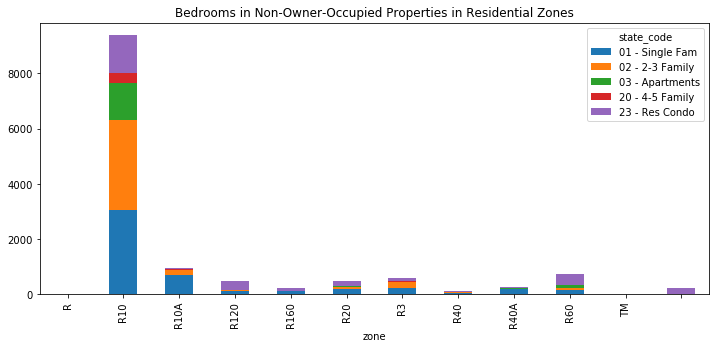

In [93]:
property_data[property_data['owner_occupied'] == False].groupby(['state_code', 'zone'])['bedrooms'].sum().unstack().drop(['CI', 'GB', 'LB', 'WB'], axis=1).filter(['01 - Single Fam', '02 - 2-3 Family', '03 - Apartments', '20 - 4-5 Family', '23 - Res Condo'], axis=0).dropna(how='all', axis=1).dropna(how='all').T.plot.bar(figsize=(12,5), stacked=True)
plt.title('Bedrooms in Non-Owner-Occupied Properties in Residential Zones')
plt.show()

In [83]:
# abb_addresses = gpd.tools.reverse_geocode(abb_data[abb_data['neighbourhood']=='Newport'].geometry, provider='photon').reset_index()